# Import

## library

In [2]:
import os 
import operator
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import pandas as pd
import random
from glob import glob
from tqdm import tqdm
from pandas.tseries.offsets import DateOffset
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from IPython.display import set_matplotlib_formats

sns.set(style='white', context='notebook', palette='deep')
line_color = ['#FFBF00','#FF7F50','#DE3163','#9FE2BF','#40E0D0','#6495ED','#117A65','#2471A3','#CCCCFF','#8E44AD','#CD5C5C' ,'#F08080','#FA8072' ,'#E9967A' ,'#FFA07A']
plt.style.use('fivethirtyeight')
plt.style.use("seaborn-white")
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False
#print(plt.rcParams['font.family'])
%matplotlib inline

In [23]:
#? 파이프라인
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

#? scaler
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler


#? 통계
#import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from scipy.stats import mstats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

#? 평가지표
import hydroeval as he
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#?모델 
import lazypredict
from lazypredict.Supervised import LazyRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split

#?모델링 
import joblib
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.inspection import permutation_importance

## function

In [4]:
# 예측과 실제 수위를 scatter plot해주는 함수 
def scatter_plot(pred,answer):
    x = pred
    y = answer

    fig, axes = plt.subplots(1, 1, figsize=(7, 7))
    rmse,nse,r2=metric(y,x)
    axes.scatter(x, y, label='data') 
    lims = [np.min([axes.get_xlim(), axes.get_ylim()]), np.max([axes.get_xlim(), axes.get_ylim()]), ]
    axes.plot(lims, lims, 'k--', alpha=0.75, zorder=0, label='parity')
    axes.set_aspect('equal')
    axes.set_xlabel('Prediction',fontsize=25)
    axes.set_ylabel('Observation',fontsize=25)
    handles, labels = axes.get_legend_handles_labels()
    txt1="(a)   Jamsu bridge RMSE %.4f"%rmse
    axes.set_title(txt1, fontsize=25,loc='left')
    axes.xaxis.set_tick_params(labelsize=20)
    axes.yaxis.set_tick_params(labelsize=20)

    return fig

In [46]:
# 파일이 존재하는지 확인하는 함수 
def check(filepath):
    csv_files = glob(os.path.join(filepath, "*.csv"))
    if len(csv_files) > 0:return 1
    else:return 0
    
# 그래프에 rmse를 표시해주는 함수 
def plot_rmse(ax, answer, preds, label):
        ax.text(1.0, 0.95, '  RMSE: {:.3f}  '.format(metric(answer,preds)[0]),
                fontsize=80, ha='right', va='top', transform=ax.transAxes)
        
# rmse와 nse를 계산해주는 함수(m단위)
def metric(y_true, y_pred):
    y_true=y_true/100
    y_pred=y_pred/100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    nse=he.evaluator(he.nse, y_pred, y_true)
    return rmse,nse,r2

In [82]:
# 선행시간, 이동평균, 윈도우에 맞게 데이터셋을 제공 
def load_dataset2(leadtime,moving_average,version):
    
    # 이동평균을 적용할 feature들 
    select_features=['cd_br','hj_br','jn_br','tl_gh_br','flow','water']
    # feature engineering 할 유량들.
    fe_list=['cd_br','hj_br','jn_br']
    
    x=pd.concat([train_data,test_data],axis=0)
    x.reset_index(drop=True,inplace=True)
    x=x.set_index('ymdhm')
    x.index=pd.to_datetime(x.index)
    
    
    # 선행시간을 적용하기 위해 타겟을미뤄줌 
    y=x['target'].shift(-leadtime)
    x.drop('target',axis=1,inplace=True)
    
    # feature engineer을 안함(유량정보없음)
    if(version==0):
        x.drop(['fw_cd_br','fw_hj_br','fw_jn_br'],axis=1,inplace=True)
    # feature engineering 함(유량정보있고, 팔당댐도 엔지니어링)
    if(version==1):
        # feature engineering한 버전
        # x['otfinf']=x['tototf_pd_dam']-x['inf_pd_dam']
        x.drop([ 'ecpc_pd_dam'],axis=1,inplace=True)
        
        # 월과 시간에 대한 feature도 추가해줌 
        x['month'],x['hour']=x.index.month,x.index.hour
        
        #! 유량 컬럼의 상관관계가 높아, 
        #! 이전시간과의 유량차이 column을 추가 
        
        flow = PCA(n_components=1)
        flow.fit(x[['tototf_pd_dam','inf_pd_dam']])
        transformed_data = flow.transform(x[['tototf_pd_dam','inf_pd_dam']])  # 변환된 데이터
        x['flow']=transformed_data
        
        water = PCA(n_components=1)
        water.fit(x[['sfw_pd_dam','wl_pd_dam']])
        transformed_data = water.transform(x[['sfw_pd_dam','wl_pd_dam']])  # 변환된 데이터
        x['water']=transformed_data
        
        x.drop(['tototf_pd_dam','inf_pd_dam','sfw_pd_dam','wl_pd_dam'],axis=1,inplace=True)
        
        fe_list=['cd_br','hj_br','jn_br']
        for i in fe_list:
            v_name = f"{i}_pca"  # 동적으로 생성할 변수명
            f_name,w_name = "fw_"+i, 'wl_'+i
            tmp=x[[f_name,w_name]]
            globals()[v_name] = PCA(n_components=1)  # 변수 생성
            globals()[v_name].fit(tmp)  # PCA 수행
            transformed_data = globals()[v_name].transform(tmp)  # 변환된 데이터
            x[i]=transformed_data
            x.drop([f_name,w_name],axis=1,inplace=True)
            if(moving_average<1): x.drop([w_name],axis=1,inplace=True)
       
    
    # 이동평균을 적용
    if(moving_average>1):
        for i in range(len(select_features)):
            coln=select_features[i]+str(moving_average)+'ma'
            x[coln] = x[select_features[i]].rolling(window=moving_average).mean()
            if(i<4):x.drop(select_features[i],axis=1,inplace=True)
        
    # train과 test를 다시 분리       
    idx = x.index.get_loc('2022-06-21 00:00:00')
    
    # test를 위해 train과 test의 범위를 선행시간만큼 조정 
    x_train=x[:idx-leadtime]
    x_test=x[idx-leadtime:]
    y_train = y[:idx - leadtime]
    
    if(version==1 and moving_average==0):
        x_train=x_train[1:]
        y_train=y_train[1:]

    # 이동평균을 적용하면 생기는 nan을 없애주기 위함 
    if(moving_average!=0):
        x_train=x_train[moving_average:]
        y_train=y_train[moving_average:]
        
    dataset=[x_train,x_test,y_train]
    
    return dataset

In [ ]:
# 선행시간, 이동평균, 윈도우에 맞게 데이터셋을 제공 
def load_dataset(leadtime,moving_average,version):
    
    # 이동평균을 적용할 feature들 
    select_features=['wl_js_br','wl_cd_br','wl_hj_br','wl_jn_br','wl_pd_dam','tl_gh_br']
    # feature engineering 할 유량들.
    fe_list=['cd_br','hj_br','jn_br']
    
    x=pd.concat([train_data,test_data],axis=0)
    x.reset_index(drop=True,inplace=True)
    x=x.set_index('ymdhm')
    x.index=pd.to_datetime(x.index)
    
    # 선행시간을 적용하기 위해 타겟을미뤄줌 
    y=x['target'].shift(-leadtime)
    x.drop('target',axis=1,inplace=True)
    
    # feature engineer을 안함(유량정보없음)
    if(version==0):
        x.drop(['fw_cd_br','fw_hj_br','fw_jn_br'],axis=1,inplace=True)
    # feature engineering 함(유량정보있고, 팔당댐도 엔지니어링)
    if(version==1):
        # feature engineering한 버전
        x['otfinf']=x['tototf_pd_dam']-x['inf_pd_dam']
        x.drop([ 'inf_pd_dam','ecpc_pd_dam', 'tototf_pd_dam'],axis=1,inplace=True)
        
        # 월과 시간에 대한 feature도 추가해줌 
        x['month'],x['hour']=x.index.month,x.index.hour
        
        #! 유량 컬럼의 상관관계가 높아, 
        #! 이전시간과의 유량차이 column을 추가 
        for i in fe_list:
            name1='fw_'+i
            name2='fw_'+i+'_lag'

            x[name2]= x[name1] - x[name1].shift(1)
            x.drop(name1,axis=1,inplace=True)
    
            
    # 이동평균을 적용
    if(moving_average>1):
        for i in range(len(select_features)):
            coln=select_features[i]+str(moving_average)+'ma'
            x[coln] = x[select_features[i]].rolling(window=moving_average).mean()
        
    # train과 test를 다시 분리       
    idx = x.index.get_loc('2022-06-21 00:00:00')
    
    # test를 위해 train과 test의 범위를 선행시간만큼 조정 
    x_train=x[:idx-leadtime]
    x_test=x[idx-leadtime:]
    y_train = y[:idx - leadtime]
    
    if(version==1 and moving_average==0):
        x_train=x_train[1:]
        y_train=y_train[1:]

    # 이동평균을 적용하면 생기는 nan을 없애주기 위함 
    if(moving_average!=0):
        x_train=x_train[moving_average:]
        y_train=y_train[moving_average:]
        
    dataset=[x_train,x_test,y_train]
    
    return dataset

In [7]:
def create_model(filepath,epoch,base_set):
    
    print("Modeling Start*******")
    # optuna 학습 
    study_model = optuna.create_study(direction='minimize', sampler=sampler)
    
    # early-stopping callback 추가
    early_stopping = EarlyStoppingCallback(15, direction='minimize')
    study_model.optimize(objective_randomforest, epoch, callbacks=[early_stopping])
    
    # optuna 학습결과 파라미터 가져오기
    trial = study_model.best_trial
    trial_params = trial.params
    print(" Value: ", trial.value)
    print(" Params: ")
    for key, value in trial_params.items():
        print(f"    {key}: {value}")
        
    # optuna로 학습된 파라미터로 모델 재 학습 
    model = RandomForestRegressor(**trial_params,random_state=624,) # 최적화된 파라미터를 통해 학습 
    model.fit(base_set[0], base_set[2]) 
    pred = model.predict(base_set[1])
    pred=pd.DataFrame(pred,columns=['wl_js_br'])
    pred = pred[:-1] # 선행시간 10분에 따라 미뤄줌 
    
    return pred,study_model

In [8]:
sampler = TPESampler(seed=10)

def objective_randomforest(trial):
    
    rf_param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 150),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 60),
        'n_jobs':-1
    }
    X_train, X_valid, y_train, y_valid = train_test_split(base_set[0], base_set[2], test_size=0.3, random_state=624)
    
    model = RandomForestRegressor(random_state=624, **rf_param)
    model.fit(X_train,y_train)
    
    rmse = np.sqrt(mean_squared_error(y_valid, model.predict(X_valid)))
    
    return rmse

In [9]:
class EarlyStoppingCallback(object):
    
    # 평가지수가 감소하는 방향으로 학습하면 minimize
    # 평가지수가 증가하는 방향으로 학습하면 maximize

    def __init__(self, early_stopping_rounds: int, direction: str = "minimize") -> None:
        self.early_stopping_rounds = early_stopping_rounds

        self._iter = 0

        if direction == "minimize":
            self._operator = operator.lt
            self._score = np.inf
        elif direction == "maximize":
            self._operator = operator.gt
            self._score = -np.inf
        else:
            ValueError(f"invalid direction: {direction}")

    def __call__(self, study: optuna.Study, trial: optuna.Trial) -> None:
        """Do early stopping."""
        if self._operator(study.best_value, self._score):
            self._iter = 0
            self._score = study.best_value
        else:
            self._iter += 1

        if self._iter >= self.early_stopping_rounds:
            study.stop()

# Data Load and Preprocessing

## Origin data load

In [ ]:
data=pd.read_csv("../data/full_data.csv")
train_data=pd.read_csv("../data/train_data.csv")
test_data=pd.read_csv("../data/test_data.csv")

## data preprocessing

In [ ]:
train_data = train_data.set_index(['ymdhm'],drop=True)
train_data.index=pd.to_datetime(train_data.index)
train_data=train_data.replace('##########',np.nan)
train_data=train_data.replace(' ',np.nan)
train_data=train_data.astype('float')
train_data.drop(['fw_js_br'],axis=1,inplace=True)
train_data.drop(['fw_gj_br'],axis=1,inplace=True)

test_data = test_data.set_index(['ymdhm'],drop=True)
test_data.index=pd.to_datetime(test_data.index)
test_data=test_data.replace('##########',np.nan)
test_data=test_data.replace(' ',np.nan)
test_data=test_data.astype('float')
test_data.drop(['fw_js_br'],axis=1,inplace=True)
test_data.drop(['fw_gj_br'],axis=1,inplace=True)

In [ ]:
rf_list=['pr_jg','pr_dg','pr_sj']
wl_list=['wl_js_br','wl_cd_br','wl_hj_br','wl_hg_br','wl_gj_br','wl_pd_br','wl_jn_br']

for col in train_data.columns:
    if(col not in rf_list):
        q1 = train_data[col].quantile(0.005)
        train_data[col][train_data[col]<q1]=np.nan
        if(col not in wl_list):
            q99 = train_data[col].quantile(0.995)
            train_data[col][train_data[col]>q99]=np.nan

    train_data[col] = train_data[col].interpolate(method='time')
train_data['wl_gj_br'] = mstats.winsorize(train_data['wl_gj_br'], limits=[0.01, 0.01])

In [ ]:
rf_list=['pr_jg','pr_dg','pr_sj']
wl_list=['wl_js_br','wl_cd_br','wl_hj_br','wl_hg_br','wl_gj_br','wl_pd_br','wl_jn_br']

for col in test_data.columns:
    if(col not in rf_list):
        q1 = test_data[col].quantile(0.005)
        test_data[col][test_data[col]<q1]=np.nan
        if(col not in wl_list):
            q99 = test_data[col].quantile(0.995)
            test_data[col][test_data[col]>q99]=np.nan
test_data['wl_gj_br'] = mstats.winsorize(test_data['wl_gj_br'], limits=[0.01, 0.01])

data=pd.concat([train_data,test_data],axis=0)

idx = data.loc[data.isna().any(axis=1)].index
idx=idx.unique()
for i in tqdm(idx):
    tmp=data[:i]
    tmp=tmp.interpolate(method='time')
    for j in data.columns:
        if pd.isna(data.loc[i, j]):
            data.loc[i][j]=tmp.iloc[-1][j]
idx = data.index.get_loc('2022-06-21 00:00:00')
test_data=data[idx:]
test_data.info()

In [ ]:
train_data=train_data[['wl_js_br', 'wl_cd_br', 'wl_hj_br','wl_hg_br', 'wl_gj_br','wl_pd_br','wl_jn_br',
                       'fw_cd_br', 'fw_hj_br', 'fw_hg_br', 'fw_pd_br','fw_jn_br',  
                       'wl_pd_dam','inf_pd_dam', 'sfw_pd_dam', 'ecpc_pd_dam', 'tototf_pd_dam', 
                       'pr_jg','pr_dg', 'pr_sj', 'tl_gh_br', ]]
test_data=test_data[['wl_js_br', 'wl_cd_br', 'wl_hj_br','wl_hg_br', 'wl_gj_br','wl_pd_br','wl_jn_br',
                       'fw_cd_br', 'fw_hj_br', 'fw_hg_br', 'fw_pd_br','fw_jn_br',  
                       'wl_pd_dam','inf_pd_dam', 'sfw_pd_dam', 'ecpc_pd_dam', 'tototf_pd_dam', 
                       'pr_jg','pr_dg', 'pr_sj', 'tl_gh_br', ]]

In [ ]:
train_data.to_csv("data/refined_train_data.csv",index=False)
test_data.to_csv("data/refined_test_data.csv",index=False)

# Refined data load

In [61]:
data=pd.read_csv("../data/new_Refined_data.csv")
train_data=pd.read_csv("../data/refined_train_data.csv")
test_data=pd.read_csv("../data/refined_test_data.csv")
answer=pd.read_csv("../data/answer.csv")

train_data['target']=train_data['wl_js_br']
test_data['target']=0
# answer

In [62]:
# 새로운 featuere 확립 

train_data.drop(['wl_hg_br','fw_hg_br','wl_gj_br','wl_pd_br','fw_pd_br'],axis=1,inplace=True)
test_data.drop(['wl_hg_br','fw_hg_br','wl_gj_br','wl_pd_br','fw_pd_br'],axis=1,inplace=True)

In [16]:
"""
1. 특정 독립 변수를 종속 변수로 선형 회귀 모델을 적합
2. 이때 해당 독립 변수를 제외한 나머지 독립 변수들을 독립 변수로 사용하여 선형 회귀 모델을 다시 적합
3. 두 번째 회귀 모델의 결정 계수(R-squared)를 구합니다.
4. VIF 값은 1 / (1 - R-squared)으로 계산됩니다.

* VIF < 1 : 다른 독립 변수들과의 상관 관계가 크지 않음 = 다중곤선성의 영향 적음.
* VIF == 1 :독립 변수 간의 상관 관계가 약하거나 전혀 없음.
* VIF > 1  :다른 독립 변수들과의 상관 관계가 강력 =  다중공선성의 영향 높음.
"""

df=load_dataset(1, 0, 0)[0]
#df=pd.concat([tmp[0],tmp[2]],axis=1)
df['Intercept'] = 1


vif_df = pd.DataFrame()
vif_df['Features'] = df.columns
vif_df['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

vif_df
high_vif_vars = vif_df[vif_df['VIF'] >= 10]['Features']
low_vif_vars = vif_df[vif_df['VIF'] < 10]['Features']

high_vif_vars=[i for i in high_vif_vars]

print("Variables with VIF >= 10:")
print(high_vif_vars)

print("Variables with VIF < 10:")
print(low_vif_vars)

'\n1. 특정 독립 변수를 종속 변수로 선형 회귀 모델을 적합\n2. 이때 해당 독립 변수를 제외한 나머지 독립 변수들을 독립 변수로 사용하여 선형 회귀 모델을 다시 적합\n3. 두 번째 회귀 모델의 결정 계수(R-squared)를 구합니다.\n4. VIF 값은 1 / (1 - R-squared)으로 계산됩니다.\n\n* VIF < 1 : 다른 독립 변수들과의 상관 관계가 크지 않음 = 다중곤선성의 영향 적음.\n* VIF == 1 :독립 변수 간의 상관 관계가 약하거나 전혀 없음.\n* VIF > 1  :다른 독립 변수들과의 상관 관계가 강력 =  다중공선성의 영향 높음.\n'

,Features,VIF
0,wl_js_br,67.49
1,wl_cd_br,12.08
2,wl_hj_br,18.01
3,wl_hg_br,114.93
4,wl_gj_br,5.21
5,wl_pd_br,19.60
6,wl_jn_br,2.26
7,fw_hg_br,3.72
8,fw_pd_br,118.03
9,wl_pd_dam,2.30


Variables with VIF >= 10:
['wl_js_br', 'wl_cd_br', 'wl_hj_br', 'wl_hg_br', 'wl_pd_br', 'fw_pd_br', 'inf_pd_dam', 'sfw_pd_dam', 'ecpc_pd_dam', 'tototf_pd_dam', 'Intercept']
Variables with VIF < 10:
4      wl_gj_br
6      wl_jn_br
7      fw_hg_br
9     wl_pd_dam
14        pr_jg
15        pr_dg
16        pr_sj
17     tl_gh_br
Name: Features, dtype: object


## Correlation heatmap

###  선행시간에 따른 target 과 나머지 feature간의 상관관계

In [ ]:
days_list=[1,3,6,9,12,15,18,24,30,36,48,60]
df_list=[]

for i in range(len(days_list)):
    tmp=load_dataset(days_list[i], 6, 1)
    df=pd.concat([tmp[0],tmp[2]],axis=1)
    df=df[:497800] # 데이터의 갯수가 같도록 임의의 숫자 
    corr = df.corrwith(df['target']).drop('target')
    corr_df = pd.DataFrame(corr, columns=['correlation'])
    corr_df.index.name = 'variables'
    corr_df['dataset'] = int(days_list[i])
    df_list.append(corr_df)
final_corr=pd.concat(df_list)

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
heatmap = sns.heatmap(final_corr.pivot_table(values='correlation', index='dataset', columns='variables'), 
                      vmax=1, linewidths=0.1, square=True, annot=True, cmap=cmap, vmin=-1,
                      linecolor="white", annot_kws={'size': 10},
                      cbar_kws={'fraction': 0.05, 'pad': 0.03,'aspect': 11})

heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=10,rotation=45)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=10,rotation=360)

plt.show();
#fig.savefig(f"image/선행시간target히트맵", transparent = True,dpi=300, bbox_inches='tight');

### correlation between all_data(all)

In [ ]:
base_set=load_dataset(1,0,0)[0]
corr = base_set.corr()
sns.set(font_scale=2)
cols=[i for i in base_set.columns]
fig, ax = plt.subplots(figsize=(35,35))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
heatmap = sns.heatmap(corr, vmax=1, linewidths=0.1, square=True, annot=True, cmap=cmap, vmin=-1,
            linecolor="white",xticklabels = cols ,annot_kws = {'size':25},yticklabels = cols,
            cbar_kws={'fraction':0.05, 'pad':0.03})

heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=30)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=30,rotation=360)

plt.show();
#fig.savefig(f"image/상관계수히트맵", transparent = True,dpi=300, bbox_inches='tight');

## 다중공산성 확인하기

### VIF

In [ ]:
"""
변수 제거: VIF 값이 10 이상인 변수 제거. 

변수 변환: 다중공선성을 완화하기 위해 변수를 변환-> 표준화,로그 변환

변수 결합: 다중공선성이 있는 변수들을 결합하여 새로운 변수를 생성. 

주성분 분석(PCA): PCA를 사용하여 다중공선성이 있는 변수들을 주성분으로 변환하여 변수들 간의 선형 종속성을 최소화

"""

In [57]:
"""
1. 특정 독립 변수를 종속 변수로 선형 회귀 모델을 적합
2. 이때 해당 독립 변수를 제외한 나머지 독립 변수들을 독립 변수로 사용하여 선형 회귀 모델을 다시 적합
3. 두 번째 회귀 모델의 결정 계수(R-squared)를 구합니다.
4. VIF 값은 1 / (1 - R-squared)으로 계산됩니다.

* VIF < 1 : 다른 독립 변수들과의 상관 관계가 크지 않음 = 다중곤선성의 영향 적음.
* VIF == 1 :독립 변수 간의 상관 관계가 약하거나 전혀 없음.
* VIF > 1  :다른 독립 변수들과의 상관 관계가 강력 =  다중공선성의 영향 높음.
"""

df=load_dataset2(1, 0, 1)[0]
#df=pd.concat([tmp[0],tmp[2]],axis=1)
df['Intercept'] = 1

vif_df = pd.DataFrame()
vif_df['Features'] = df.columns
vif_df['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

vif_df
high_vif_vars = vif_df[vif_df['VIF'] >= 10]['Features']
low_vif_vars = vif_df[vif_df['VIF'] < 10]['Features']

high_vif_vars=[i for i in high_vif_vars]

print("Variables with VIF >= 10:")
print(high_vif_vars)

print("Variables with VIF < 10:")
print(low_vif_vars)

'\n1. 특정 독립 변수를 종속 변수로 선형 회귀 모델을 적합\n2. 이때 해당 독립 변수를 제외한 나머지 독립 변수들을 독립 변수로 사용하여 선형 회귀 모델을 다시 적합\n3. 두 번째 회귀 모델의 결정 계수(R-squared)를 구합니다.\n4. VIF 값은 1 / (1 - R-squared)으로 계산됩니다.\n\n* VIF < 1 : 다른 독립 변수들과의 상관 관계가 크지 않음 = 다중곤선성의 영향 적음.\n* VIF == 1 :독립 변수 간의 상관 관계가 약하거나 전혀 없음.\n* VIF > 1  :다른 독립 변수들과의 상관 관계가 강력 =  다중공선성의 영향 높음.\n'

KeyError: ('tototf_pd_dam', 'inf_pd_dam')

# Modeling

## Model selelct(automl-lazypredict)

In [ ]:
#for idx,i in enumerate(lazypredict.Supervised.REGRESSORS):
#    print(idx,i)
reg_list=[]
for idx,i in enumerate(lazypredict.Supervised.REGRESSORS):
    if(idx in [33,40,41]):
        reg_list.append(i)
reg_list.append(('CatBoostRegressor',CatBoostRegressor))
lazypredict.Supervised.REGRESSORS=reg_list

In [ ]:
filepath='../result/base_model/'
if(check(filepath)==0): # 해당경로에 없을 때
    base_set=load_dataset(1,0,0) # x_train,x_test,y_train,y_test
    X_train, X_valid, y_train, y_valid = train_test_split(base_set[0], base_set[2], test_size=0.33, random_state=624)
    model = LazyRegressor(verbose=1, ignore_warnings=True)
    pred,result= model.fit(X_train, X_valid, y_train, y_valid)
    result.head()

In [47]:
model_scores=[]

## Base model

columns=['wl_js_br', 'wl_cd_br', 'wl_hj_br', 'wl_jn_br', 'wl_pd_dam', <br>
       'inf_pd_dam', 'sfw_pd_dam', 'ecpc_pd_dam', 'tototf_pd_dam', 'pr_jg',<br>
       'pr_dg', 'pr_sj', 'tl_gh_br']

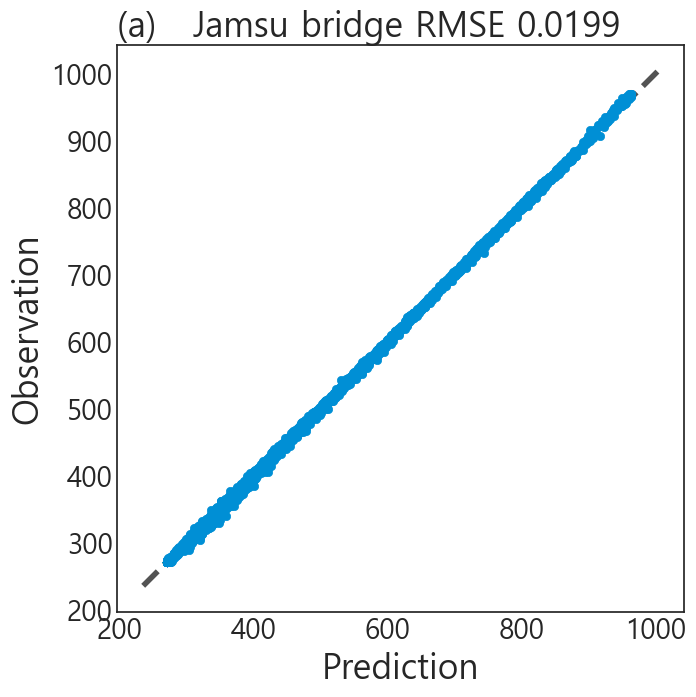

In [48]:
filepath='../result/base_model/'

if(check(filepath)==0): # 해당경로에 없을 때
    base_set=load_dataset(1,0,0)
    base_set[0].columns
    model = RandomForestRegressor(random_state=624,n_jobs=-1)
    pred=model.fit(base_set[0], base_set[2])
    pred=model.predict(base_set[1])
    pred=pd.DataFrame(pred,columns=['wl_jamsu'])
    pred=pred[:-1]
    pred.to_csv(f"{filepath}preds.csv",index=False)
    joblib.dump(model, f"{filepath}wl_jamsu.pkl")
    fig=scatter_plot(answer,pred)
    fig.savefig(f"../image/베이스라인pred", transparent = True,dpi=300, bbox_inches='tight')
else:
    pred=pd.read_csv(f"{filepath}preds.csv")
    model_scores.append(metric(answer,pred)[0])
    fig=scatter_plot(answer,pred) 

## Feature engineering model

columns=['wl_js_br', 'wl_cd_br', 'wl_hj_br', 'wl_jn_br', 'wl_pd_dam', <br>
       'sfw_pd_dam', 'pr_jg', 'pr_dg', 'pr_sj', 'tl_gh_br', 'otfinf', 'month', <br>
       'hour', 'fw_cd_br_lag', 'fw_hj_br_lag', 'fw_jn_br_lag'] <br>

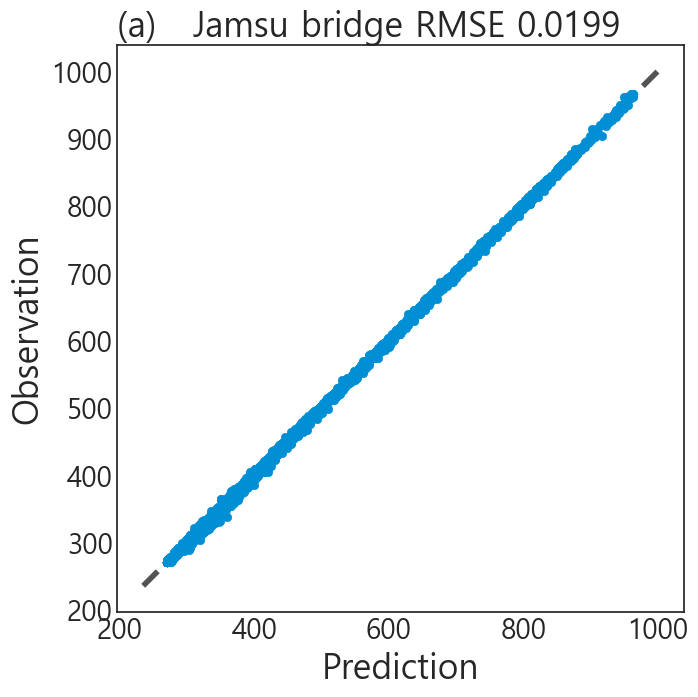

In [87]:
filepath='../result/new_model/'
if(check(filepath)==0): # 해당경로에 없을 때
    base_set=load_dataset2(1,0,1)
    base_set[0].columns
    model = RandomForestRegressor(random_state=624,n_jobs=-1)
    pred=model.fit(base_set[0], base_set[2])
    pred=model.predict(base_set[1])
    pred=pd.DataFrame(pred,columns=['wl_jamsu'])
    pred=pred[:-1]
    pred.to_csv(f"{filepath}preds.csv",index=False)
    #joblib.dump(model, f"{filepath}wl_jamsu.pkl")
    fig=scatter_plot(answer,pred)
    #fig.savefig(f"image/엔지니어pred", transparent = True,dpi=300, bbox_inches='tight')
else:
    pred=pd.read_csv(f"{filepath}preds.csv")
    model_scores.append(metric(answer,pred)[0])
    fig=scatter_plot(answer,pred) 

## moving average=6 /Feature engineering model 

columns=['wl_js_br', 'wl_cd_br', 'wl_hj_br', 'wl_jn_br', 'wl_pd_dam',  <br>
       'sfw_pd_dam', 'pr_jg', 'pr_dg', 'pr_sj', 'tl_gh_br', 'otfinf', 'month', <br>
       'hour', 'fw_cd_br_lag', 'fw_hj_br_lag', 'fw_jn_br_lag', 'wl_js_br6ma',<br>
       'wl_cd_br6ma', 'wl_hj_br6ma','wl_jn_vr6ma', 'wl_pd_dam6ma', 'tl_gh_br6ma']<br>

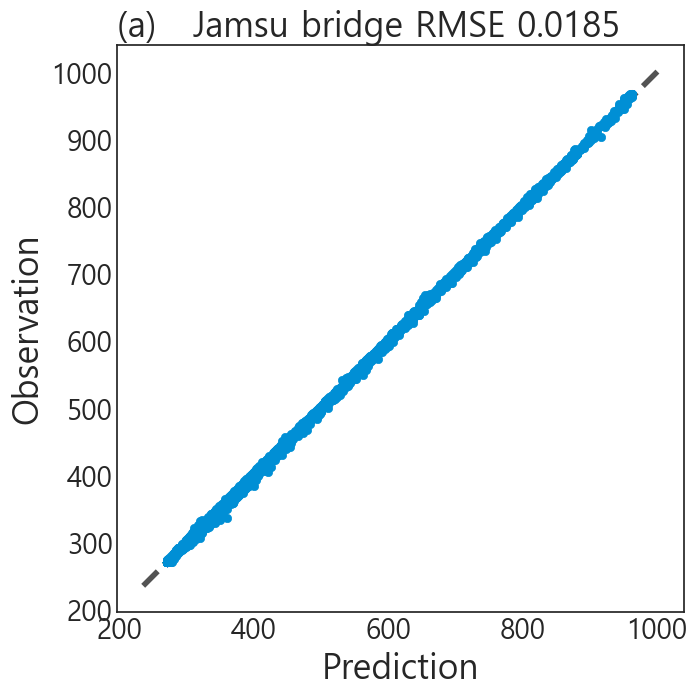

In [86]:
filepath='../result/new_model2/'
if(check(filepath)==0): # 해당경로에 없을 때
    base_set=load_dataset2(1,6,1)
    base_set[0].columns
    model = RandomForestRegressor(random_state=624,n_jobs=-1)
    pred=model.fit(base_set[0], base_set[2])
    pred=model.predict(base_set[1])
    pred=pd.DataFrame(pred,columns=['wl_jamsu'])
    pred=pred[:-1]
    pred.to_csv(f"{filepath}preds.csv",index=False)
    fig=scatter_plot(answer,pred)
else:
    pred=pd.read_csv(f"{filepath}preds.csv")
    model_scores.append(metric(answer,pred)[0])
    fig=scatter_plot(answer,pred) 

## moving average=6 /Feature engineering model / hyper paramete optimized

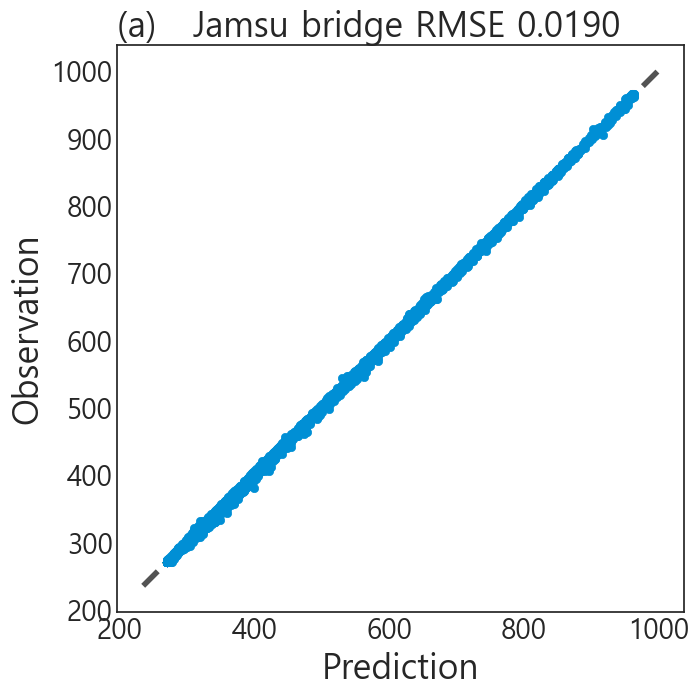

In [85]:
filepath='../result/new_model3/'
if(check(filepath)==0): # 해당경로에 없을 때
    base_set=load_dataset2(1,6,1)
    pred,model=create_model(filepath,100,base_set)
    pred.to_csv(f"{filepath}preds.csv",index=False)
    joblib.dump(model, f"{filepath}optimized_wl_jamsu.pkl") 
    fig=scatter_plot(answer,pred)
else:
    pred=pd.read_csv(f"{filepath}preds.csv")
    fig=scatter_plot(answer,pred)

# Result ( by model with lead time)

##  base model result

In [ ]:
filepath = "../result/base_model/leadtime/" # basic

preds_list,scores=[],[]
days_list=[1,3,6,9,12,18,24,30,36,48,60,72]

if(check(filepath)==0): # 해당경로에 없을 때
    for i in tqdm(range(len(days_list))):
        print("#"*50)
        print("LeadTime=%d"%days_list[i])
        print("Modeling Start")
        base_set=load_dataset(days_list[i],0,0)
        model=RandomForestRegressor(n_jobs=-1,random_state=624)
        model = model.fit(base_set[0],base_set[2])
        pred = model.predict(base_set[1])
        pred=pd.DataFrame(pred,columns=['wl_jamsu'])
        pred=pred[:-days_list[i]]
        print("RMSE score is %f / NSE score is %f"%(metric(answer,pred)[0],metric(answer,pred)[1]))
        preds_list.append(pred)
        pred.to_csv(f"{filepath}wl_jamsu({days_list[i]}).csv",index=False)
        #joblib.dump(model, f"D:/{filepath}wl_jamsu({days_list[i]}).pkl")       
        print("Modeling END")
        
        del base_set
        del model
else:
    for i in tqdm(range(len(days_list))):
        tmp=pd.read_csv(f"{filepath}wl_jamsu({days_list[i]}).csv")
        #preds_list.append(tmp)
        scores.append(metric(answer,tmp)[0])
        #print("#"*50)
        #print("LeadTime=%d"%days_list[i])
        #print("RMSE score is %f / NSE score is %f"%(metric(answer,tmp)[0],metric(answer,tmp)[1]))
        #print("#"*50)

## Feature engineering model result

In [ ]:
filepath = "../result/model/leadtime/" # feature

preds_list,scores2=[],[]
days_list=[1,3,6,9,12,18,24,30,36,48,60,72]

if(check(filepath)==0): # 해당경로에 없을 때
    for i in tqdm(range(len(days_list))):
        print("#"*50)
        print("LeadTime=%d"%days_list[i])
        print("Modeling Start")
        base_set=load_dataset(days_list[i],0,1)
        model=RandomForestRegressor(n_jobs=-1,random_state=624)
        model = model.fit(base_set[0],base_set[2])
        pred = model.predict(base_set[1])
        pred=pd.DataFrame(pred,columns=['wl_jamsu'])
        pred=pred[:-days_list[i]]
        print("RMSE score is %f / NSE score is %f"%(metric(answer,pred)[0],metric(answer,pred)[1]))
        preds_list.append(pred)
        pred.to_csv(f"{filepath}wl_jamsu({days_list[i]}).csv",index=False)
        #joblib.dump(model, f"D:/{filepath}wl_jamsu({days_list[i]}).pkl")       
        print("Modeling END")
        
        del base_set
        del model
else:
    for i in tqdm(range(len(days_list))):
        tmp=pd.read_csv(f"{filepath}wl_jamsu({days_list[i]}).csv")
        preds_list.append(tmp)
        scores2.append(metric(answer,tmp)[0])
        #print("#"*50)
        #print("LeadTime=%d"%days_list[i])
        #print("RMSE score is %f / NSE score is %f"%(metric(answer,tmp)[0],metric(answer,tmp)[1]))
        #print("#"*50)

## moving_average=6 / feature engineering model result

In [ ]:
filepath = "../result/model2/leadtime/" # feature

preds_list,scores3=[],[]
days_list=[1,3,6,9,12,18,24,30,36,48,60,72]
#basic_preds_list=[]

if(check(filepath)==0): # 해당경로에 없을 때
    for i in tqdm(range(len(days_list))):
        print("#"*50)
        print("LeadTime=%d"%days_list[i])
        print("Modeling Start")
        base_set=load_dataset(days_list[i],6,1)
        model=RandomForestRegressor(n_jobs=-1,random_state=624)
        model = model.fit(base_set[0],base_set[2])
        pred = model.predict(base_set[1])
        pred=pd.DataFrame(pred,columns=['wl_jamsu'])
        pred=pred[:-days_list[i]]
        print("RMSE score is %f / NSE score is %f"%(metric(answer,pred)[0],metric(answer,pred)[1]))
        preds_list.append(pred)
        pred.to_csv(f"{filepath}wl_jamsu({days_list[i]}).csv",index=False)
        joblib.dump(model, f"D:/waterdata/result/leadtime/wl_jamsu({days_list[i]}.pkl")       
        print("Modeling END")
        
        del base_set
        del model
else:
    for i in tqdm(range(len(days_list))):
        tmp=pd.read_csv(f"{filepath}wl_jamsu({days_list[i]}).csv")
        #preds_list.append(tmp)
        scores3.append(metric(answer,tmp)[0])
        #print("#"*50)
        #print("LeadTime=%d"%days_list[i])
        #print("RMSE score is %f / NSE score is %f"%(metric(answer,tmp)[0],metric(answer,tmp)[1]))
        #print("#"*50)

## ## moving_average=6 / feature engineering / optimized model result

In [159]:
filepath = "../result/model3/leadtime/" # feature
days_list=[1,3,6,9,12,18,24,30,36,48,60,72]
preds_list,scores4=[],[]

if(check(filepath)==0):
    tmp = joblib.load(f"../result/model3/optimized_wl_jamsu.pkl")
    params = tmp.best_trial.params
    del tmp
    for i in tqdm(range(len(days_list))):
        print("#"*50)
        print("LeadTime=%d"%days_list[i])
        print("Modeling Start")
        base_set=load_dataset(days_list[i],6,1)
        model=RandomForestRegressor(**params,random_state=624,n_jobs=-1)
        model = model.fit(base_set[0],base_set[2])
        pred = model.predict(base_set[1])
        pred=pd.DataFrame(pred,columns=['wl_jamsu'])
        pred=pred[:-days_list[i]]
        print("RMSE score is %f / NSE score is %f"%(metric(answer,pred)[0],metric(answer,pred)[1]))
        preds_list.append(pred)
        pred.to_csv(f"{filepath}wl_jamsu({days_list[i]}).csv",index=False)
        joblib.dump(model, f"D:/waterdata/result/leadtime/wl_jamsu({days_list[i]}).cs")       
        print("Modeling END")
        
        del base_set
        del model
else:
    for i in tqdm(range(len(days_list))):
        tmp=pd.read_csv(f"{filepath}wl_jamsu({days_list[i]}).csv")
        preds_list.append(tmp)
        scores4.append(metric(answer,tmp)[0])
        print("#"*50)
        print("LeadTime=%d"%days_list[i])
        print("RMSE score is %f "%(metric(answer,tmp)[0]))
        #print("#"*50)

100%|██████████| 12/12 [00:00<00:00, 77.90it/s]

##################################################
LeadTime=1
RMSE score is 0.027572 
##################################################
LeadTime=3
RMSE score is 0.044121 
##################################################
LeadTime=6
RMSE score is 0.068090 
##################################################
LeadTime=9
RMSE score is 0.104741 
##################################################
LeadTime=12
RMSE score is 0.128944 
##################################################
LeadTime=18
RMSE score is 0.171735 
##################################################
LeadTime=24
RMSE score is 0.252044 
##################################################
LeadTime=30
RMSE score is 0.346596 
##################################################
LeadTime=36
RMSE score is 0.429070 
##################################################
LeadTime=48
RMSE score is 0.526920 
##################################################
LeadTime=60
RMSE score is 0.637542 
###############################################

# Visaulize Result

### 모델별 선행시간에 따른 rmse score

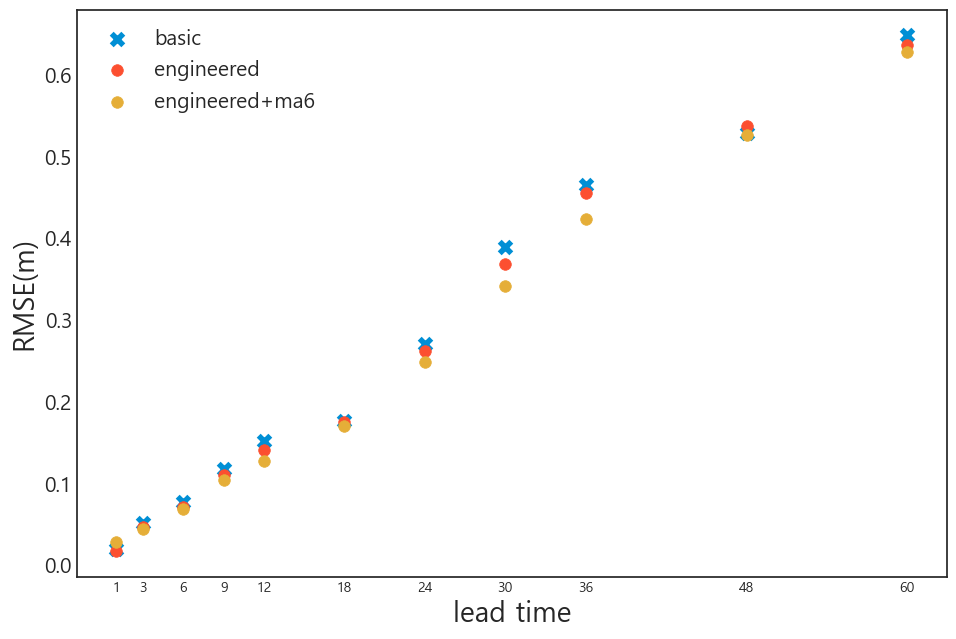

In [162]:
fig=plt.figure(figsize=(10,7))
plt.scatter(days_list[:-1], scores[:-1], s=70, label='basic',marker='x')
plt.scatter(days_list[:-1], scores2[:-1], s=70, label='engineered',marker='o')
plt.scatter(days_list[:-1], scores3[:-1], s=70, label='engineered+ma6',marker='o')
#plt.scatter(days_list[:-1], scores4[:-1], s=70, label='engineered+ma6+optimize',marker='o')


plt.legend(fontsize=15)
plt.xticks(days_list[:-1], fontsize=10)
plt.yticks(fontsize=15)

plt.xlabel("lead time", fontsize=20)
plt.ylabel("RMSE(m)", fontsize=20);

#fig.savefig(f"image/model comparison", transparent = True,dpi=300, bbox_inches='tight');

## leadtime result by model

In [ ]:
base_set=load_dataset(1,0,0)
ymdhm=base_set[1].index[1:]
ymdhm=pd.to_datetime(ymdhm)
ymdhm

### model 3 result

In [ ]:
fig=plt.figure(figsize=(30,20))
plt.title("선행시간별예측", fontsize=40)
plt.plot(ymdhm,preds_list[0]) # 선행시간 10m
plt.plot(ymdhm,preds_list[1]) # 선행시간 30m
plt.plot(ymdhm,preds_list[2]) # 선행시간 60m
plt.plot(ymdhm,preds_list[3]) # 선행시간 90m
plt.plot(ymdhm,preds_list[4]) # 선행시간 120m
plt.plot(ymdhm,preds_list[5]) # 선행시간 180m
plt.plot(ymdhm,preds_list[6]) # 선행시간 360m
plt.plot(ymdhm,preds_list[7]) # 선행시간 480m
plt.plot(ymdhm,preds_list[8]) # 선행시간 480m
plt.plot(ymdhm,preds_list[9]) # 선행시간 480m
plt.plot(ymdhm,answer,color='black')
plt.xticks(fontsize= 30)
plt.yticks(fontsize= 25)
plt.ylabel("수위",fontsize= 25)
plt.legend(['10','30','60','90','120','180','240','360','480','600','answer'],fontsize=20)
plt.show();

In [ ]:
plt.rcParams['axes.labelsize'] = 65
plt.rcParams['xtick.labelsize'] = 65
plt.rcParams['ytick.labelsize'] = 65

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(116, 80))
days_list=[1,3,6,9,12,18,24,30,36,48,60]

predslist=preds_list

colors = {'prediction': 'blue', 'observation': 'black', 'red': 'red', 'green': 'green'}
k = [0, 1 ,2, 3, 4, 5, 6, 7, 8, 9]
titles = ['(a) 10 min.', '(b) 30 min.','(c) 60 min.', '(d) 90 min.','(e) 120 min.', 
          '(f) 180 min.','(g) 240 min.', '(h) 360 min.','(i) 480 min.','(j) 600 min.']


for i, ax in enumerate(axs.flat):
    plot_rmse(ax, answer, predslist[k[i]], label='RMSE')
    ax.plot([], [], color=colors['red'], marker='o', linestyle='None', markersize=20)
    ax.plot([], [], color=colors['green'], marker='o', linestyle='None', markersize=30)
    ax.plot(ymdhm, predslist[k[i]], color=colors['prediction'])
    ax.plot(ymdhm, answer, color=colors['observation'])
    ax.set_title(titles[i], fontsize=95, loc='left', fontdict={'color': 'black'})
    ax.set(xlabel="2022",ylabel='Water level(cm)')
    
    # 날짜형식을 문자로 변경
    date_fmt = '%d %b'  
    date_formatter = mdates.DateFormatter(date_fmt)
    ax.xaxis.set_major_formatter(date_formatter)
    # subplot형태로 만들기위해 다른 label 없앰 
    
    # 중간에 수평선 그리기 
    ax.axhline(y=550, color='yellow', linestyle='--', linewidth=4)
    ax.axhline(y=620, color='yellow', linestyle='--', linewidth=4)
    
    ax.set_yticks([250, 400, 550, 620, 800,1000])
    ax.tick_params(axis='both', which='major', width=8, colors='black',labelsize=65, length=18, direction="out", bottom=True, left=True,pad=30)
    ax.label_outer()

    
    red_count,green_count = 0,0
    for j, (obs, pred) in enumerate(zip(answer['wl_js_br'], predslist[k[i]]['wl_jamsu'])):
        if obs >= 550 and pred < 550:
            ax.plot(ymdhm[j], pred, color=colors['red'], marker='o', markersize=20)
            red_count += 1
        elif obs < 550 and pred >= 550:
            ax.plot(ymdhm[j], pred, color=colors['green'], marker='o', markersize=20)
            green_count += 1
        
    # 마지막차트에는 legend 2개가 더 있어야 함        
    if(i==9):        
        ax.legend([f'False-Negative: {red_count}', f'False-Positive: {green_count}','Prediction', 'Observation'],fontsize=65)
    else:        
        ax.legend([f'False-Negative: {red_count}', f'False-Positive: {green_count}'],fontsize=65,loc='upper left')
        
    # 테두리 두껍게 안하면 안보임.
    ax.spines['top'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['left'].set_linewidth(4)
    ax.spines['right'].set_linewidth(4)
fig;


#fig.savefig(f"image/모델3 선행시간별그래프", transparent = True,dpi=300, bbox_inches='tight');

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(5, 2, figsize=(12, 20))
titles = ['(a) 10 min.', '(b) 30 min.','(c) 60 min.', '(d) 90 min.','(e) 120 min.', 
          '(f) 180 min.','(g) 240 min.', '(h) 360 min.','(i) 480 min.','(j) 600 min.']

for i in range(min(len(preds_list), 10)):  # 최대 10개의 그림을 출력하도록 수정
    predict = preds_list[i]
    
    predict['tmp'] = predict['wl_jamsu'] > 550
    answer['tmp'] = answer['wl_js_br'] > 550

    cm = confusion_matrix(answer['tmp'], predict['tmp'])
    labels = ['0', '1']

    ax = axes[i // 2, i % 2]  # 서브플롯 인덱스 설정
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('Predicted' if i == min(len(preds_list), 10) - 1 else '')
    ax.set_ylabel('Actual' if i == min(len(preds_list), 10) - 1 else '')
    ax.set_title(f'{titles[i]}')

plt.tight_layout()
plt.show();


# Permutation importacne

In [ ]:
base_set=load_dataset(days_list[i],6,1)
feature = base_set[0].columns
feature

In [ ]:
filepath="result/leadtime2/leadtime"

<Axes: xlabel='importances', ylabel='feature'>

Text(0.5, 1.0, '1 Leadtime Feature Importances(1~10)')

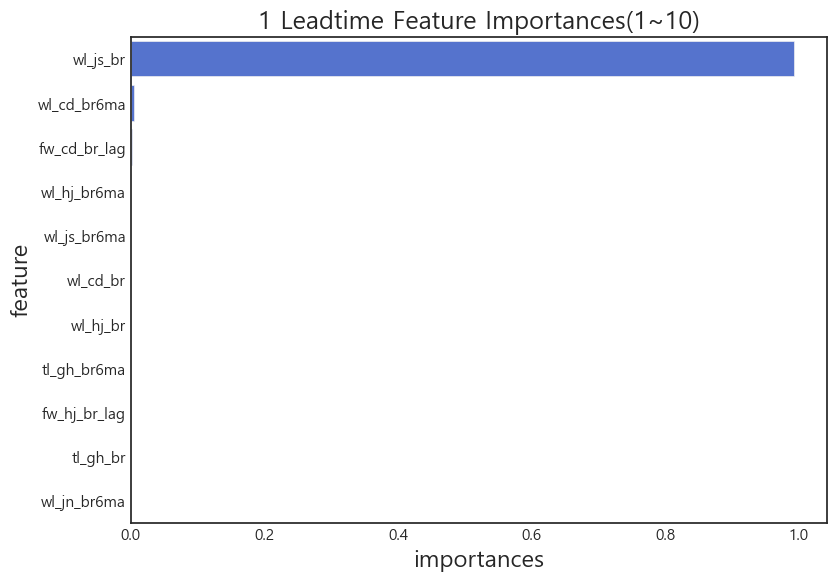

<Axes: xlabel='importances', ylabel='feature'>

Text(0.5, 1.0, '3 Leadtime Feature Importances(1~10)')

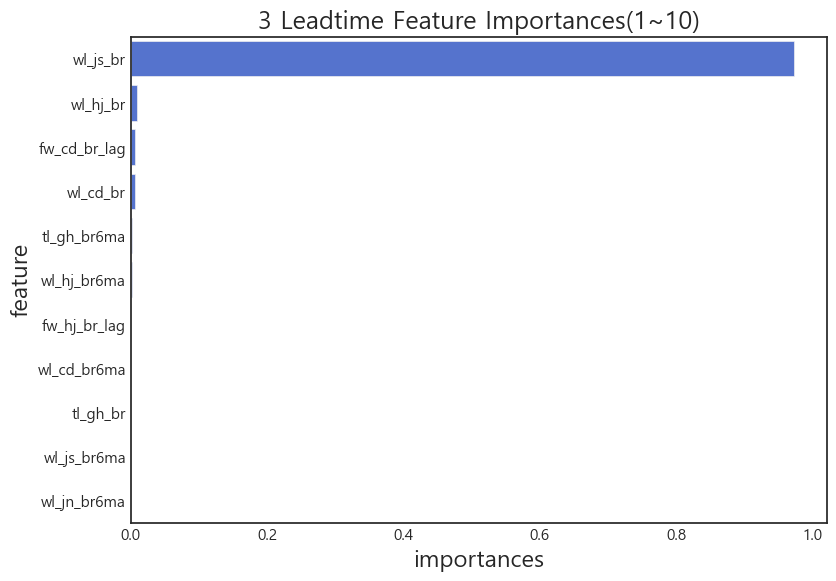

<Axes: xlabel='importances', ylabel='feature'>

Text(0.5, 1.0, '6 Leadtime Feature Importances(1~10)')

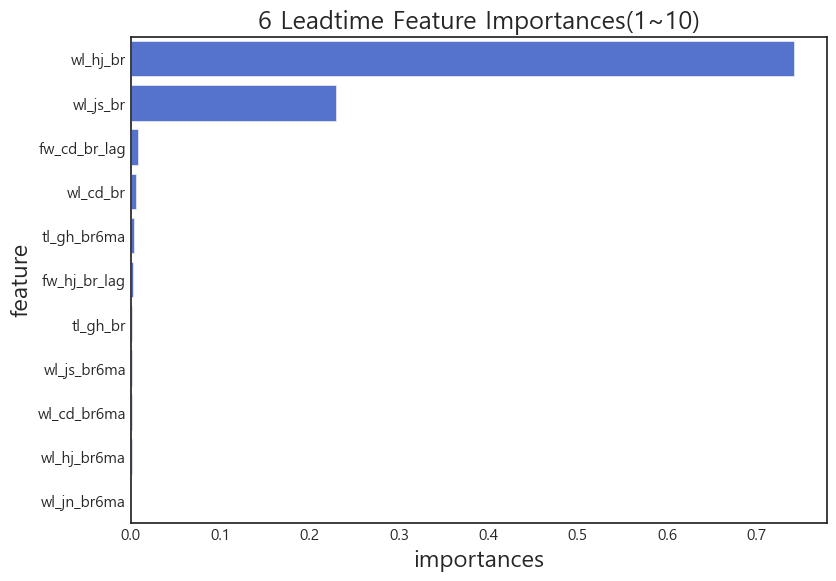

<Axes: xlabel='importances', ylabel='feature'>

Text(0.5, 1.0, '9 Leadtime Feature Importances(1~10)')

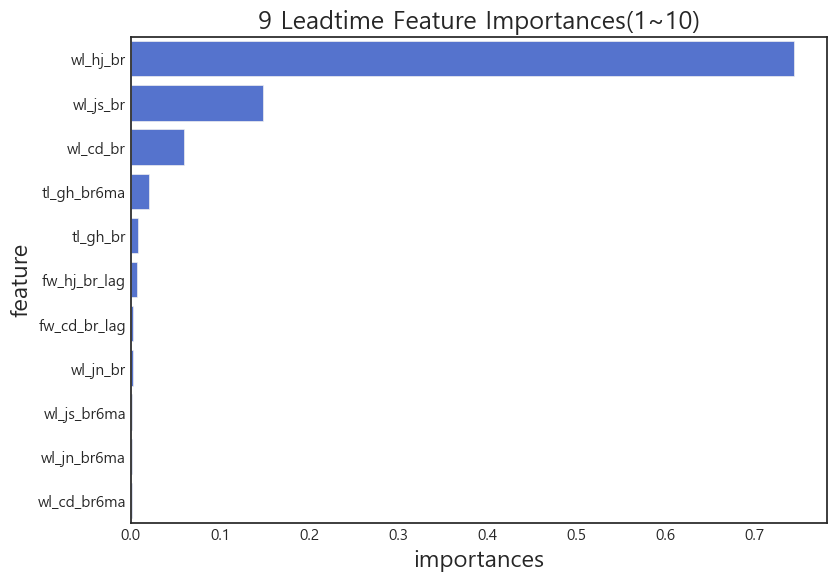

<Axes: xlabel='importances', ylabel='feature'>

Text(0.5, 1.0, '12 Leadtime Feature Importances(1~10)')

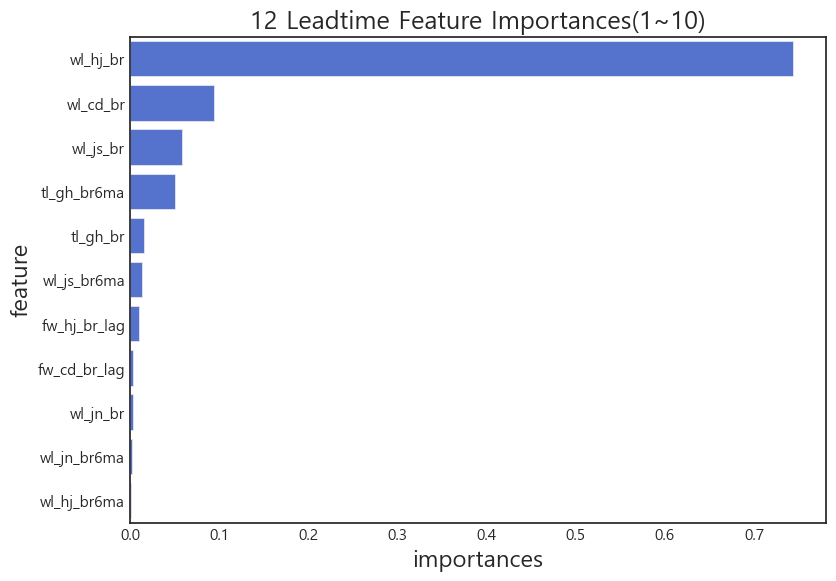

<Axes: xlabel='importances', ylabel='feature'>

Text(0.5, 1.0, '18 Leadtime Feature Importances(1~10)')

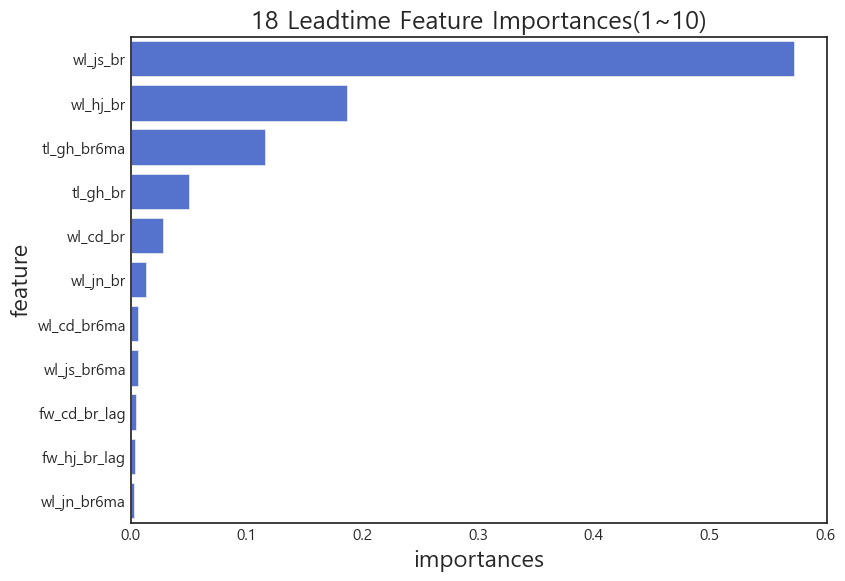

<Axes: xlabel='importances', ylabel='feature'>

Text(0.5, 1.0, '24 Leadtime Feature Importances(1~10)')

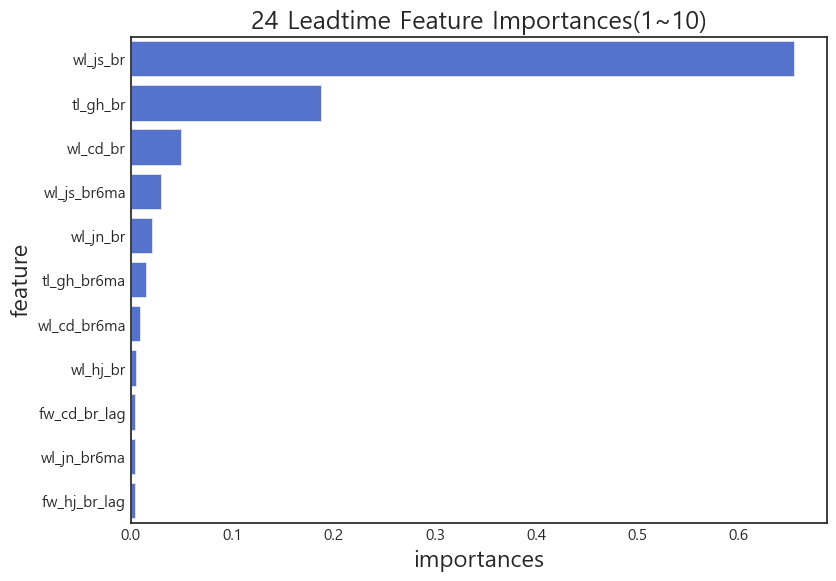

<Axes: xlabel='importances', ylabel='feature'>

Text(0.5, 1.0, '30 Leadtime Feature Importances(1~10)')

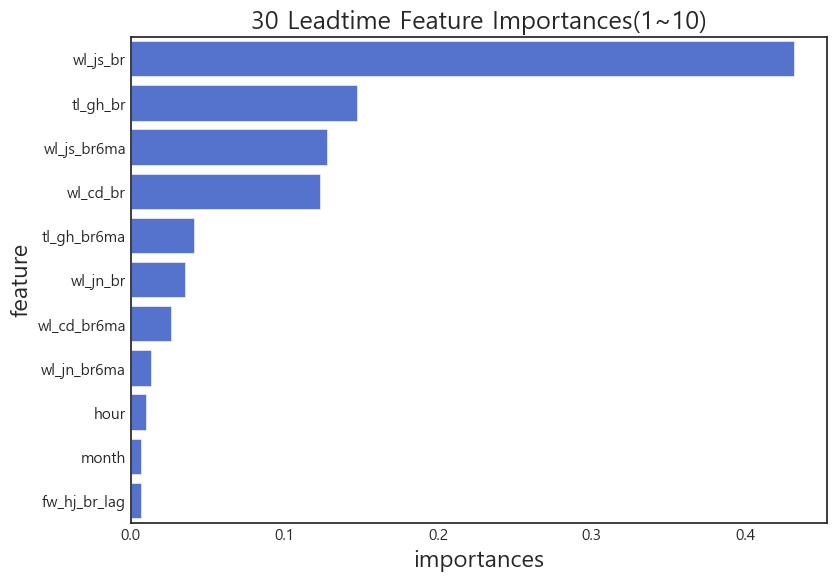

<Axes: xlabel='importances', ylabel='feature'>

Text(0.5, 1.0, '36 Leadtime Feature Importances(1~10)')

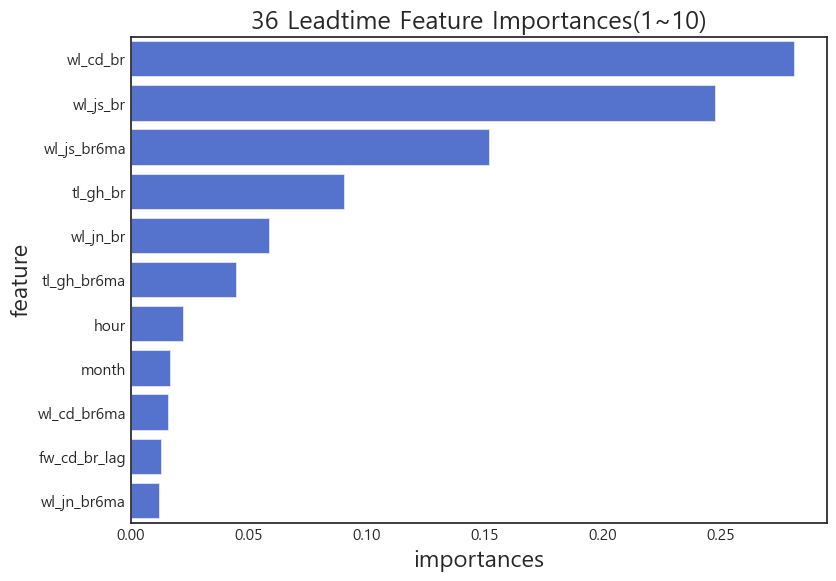

<Axes: xlabel='importances', ylabel='feature'>

Text(0.5, 1.0, '48 Leadtime Feature Importances(1~10)')

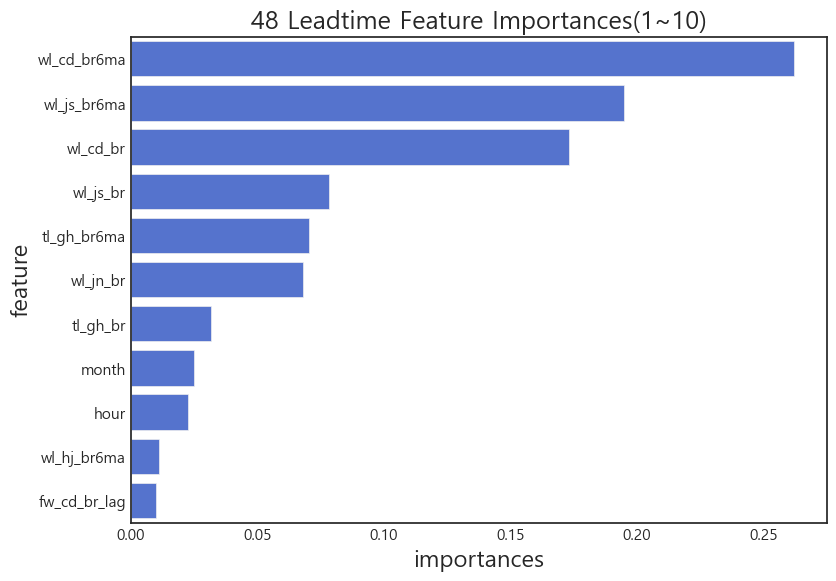

<Axes: xlabel='importances', ylabel='feature'>

Text(0.5, 1.0, '60 Leadtime Feature Importances(1~10)')

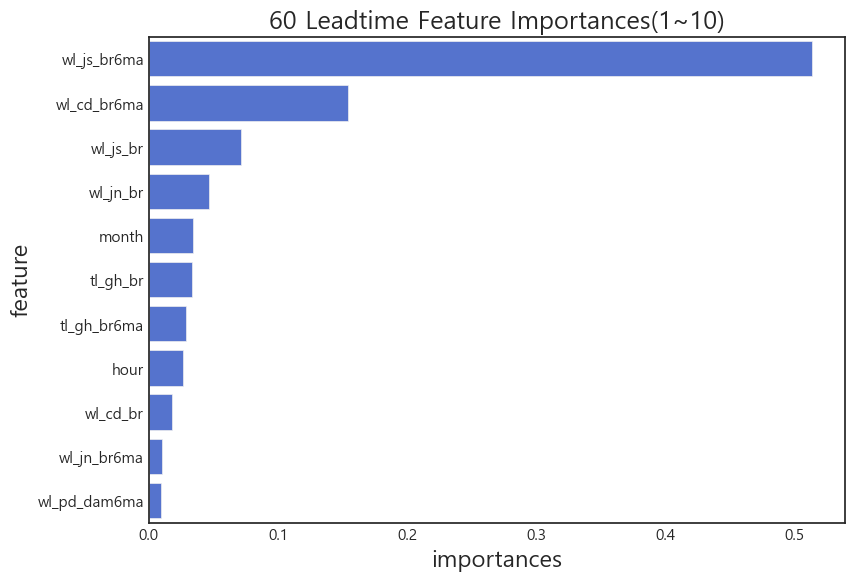

<Axes: xlabel='importances', ylabel='feature'>

Text(0.5, 1.0, '72 Leadtime Feature Importances(1~10)')

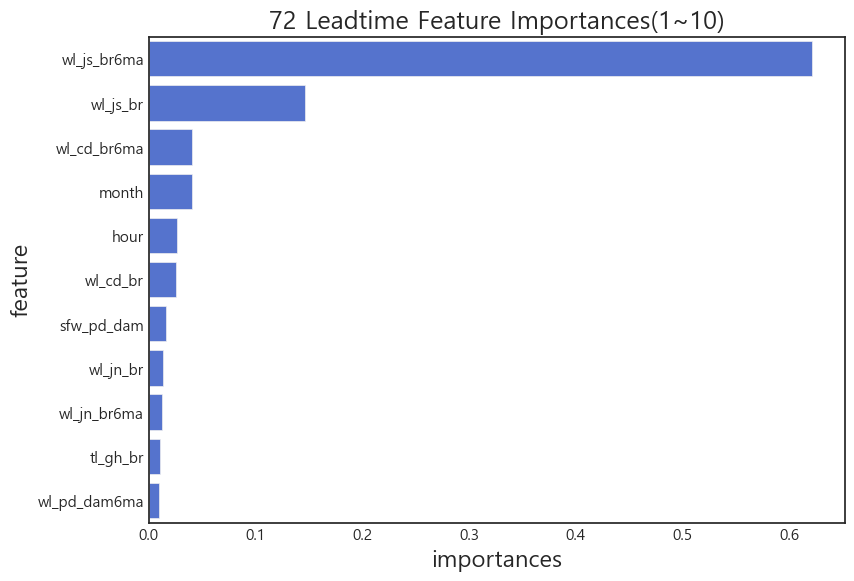

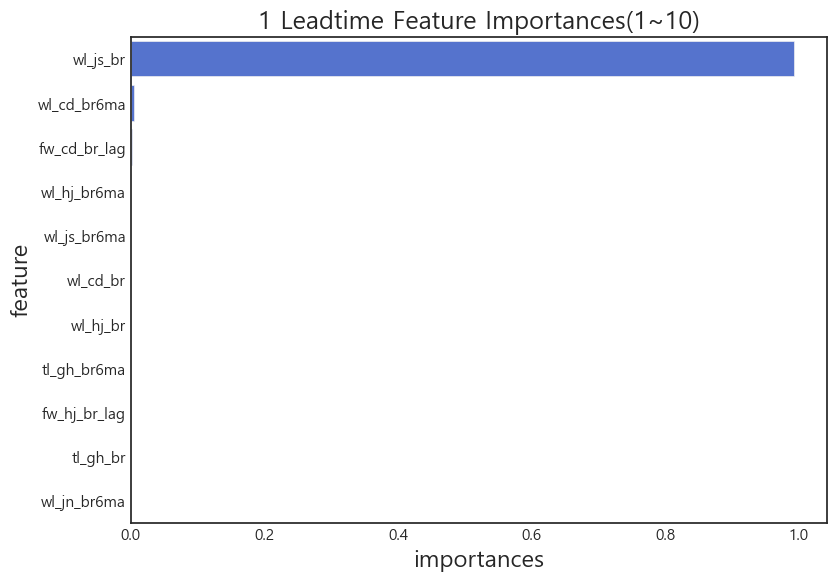

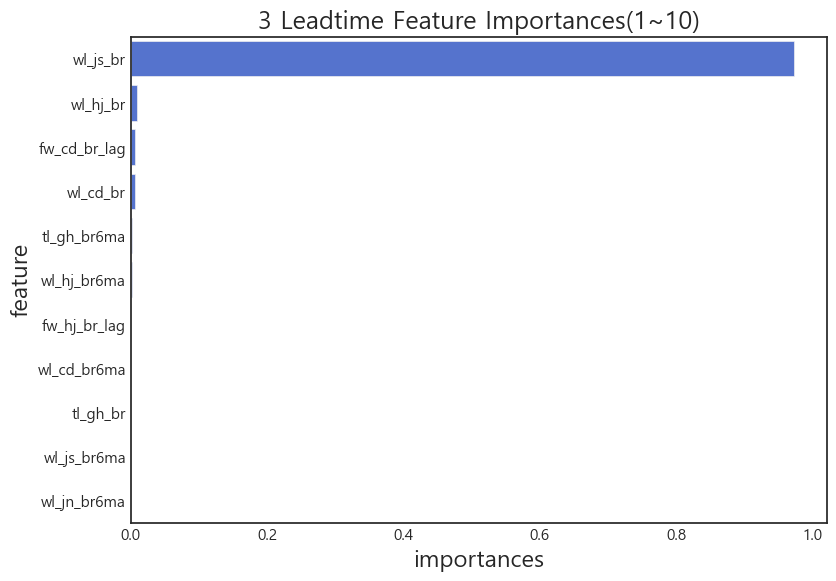

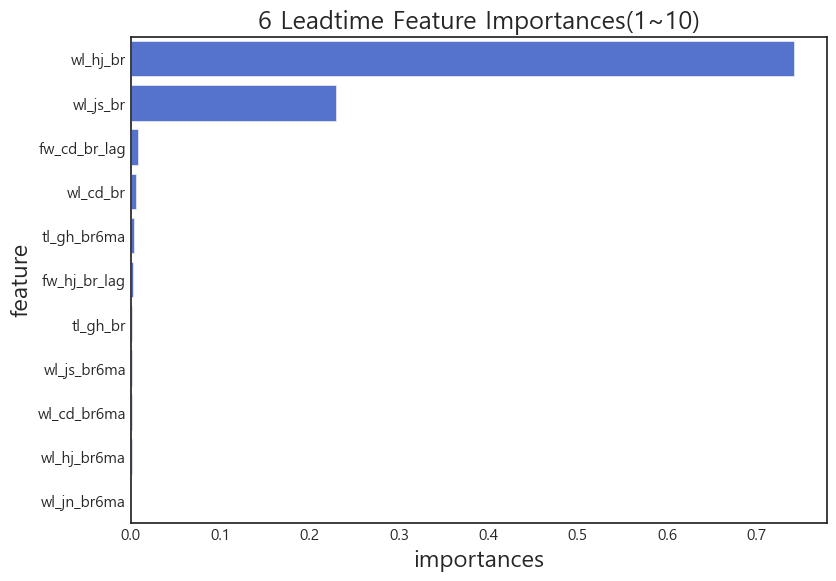

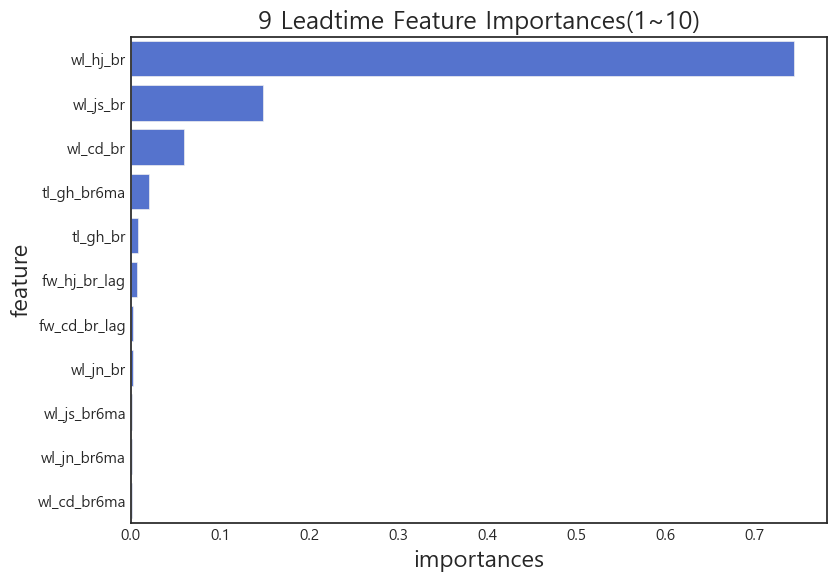

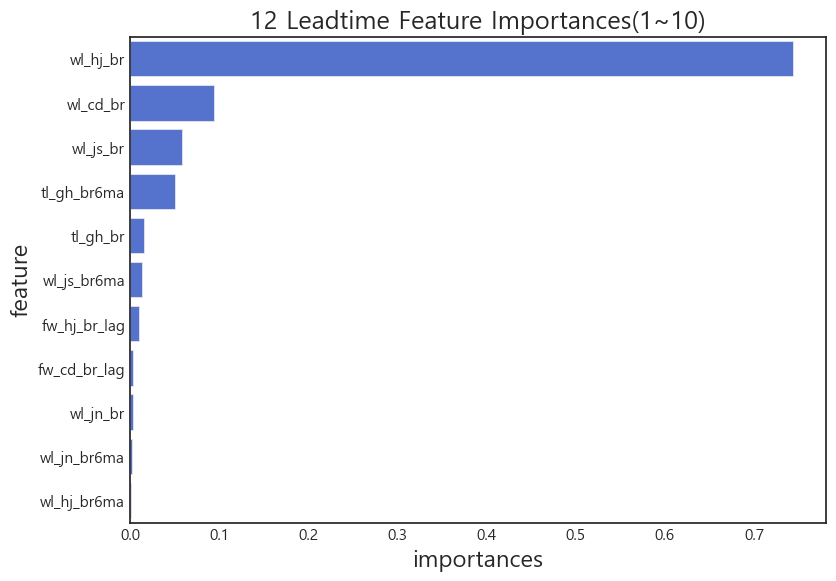

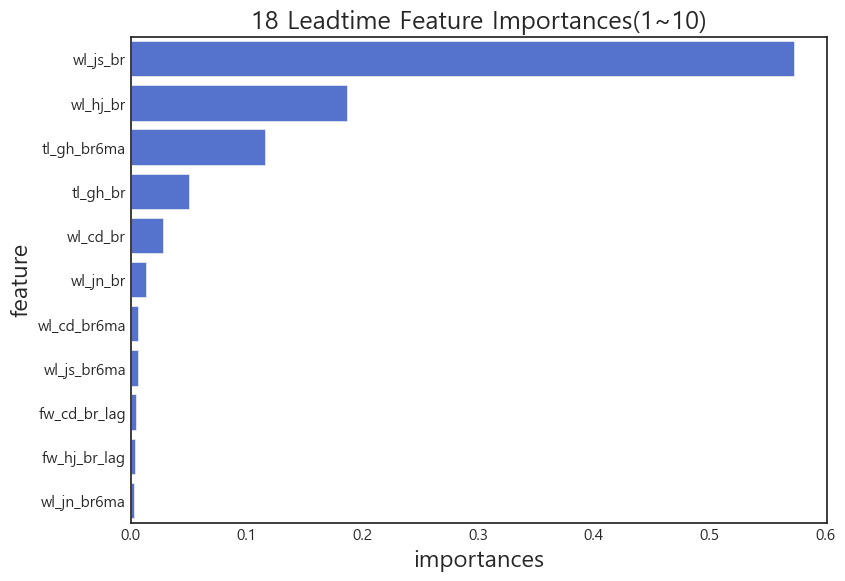

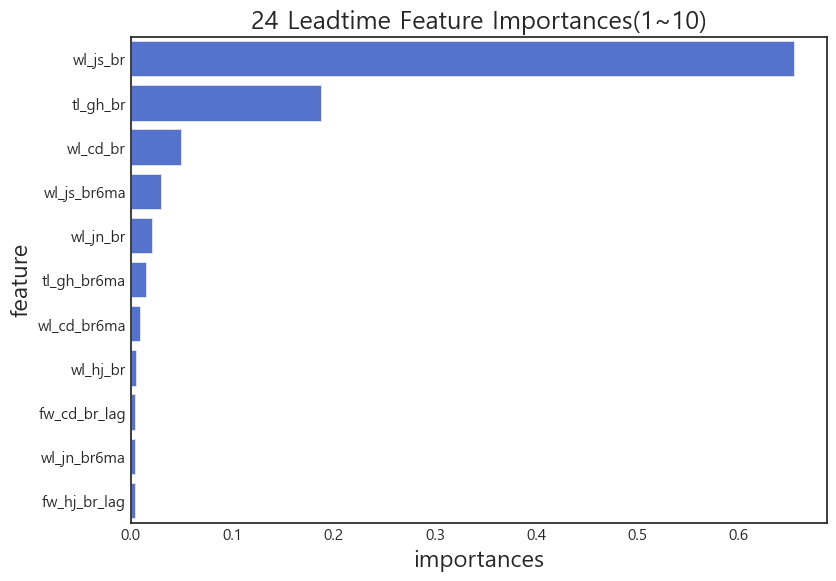

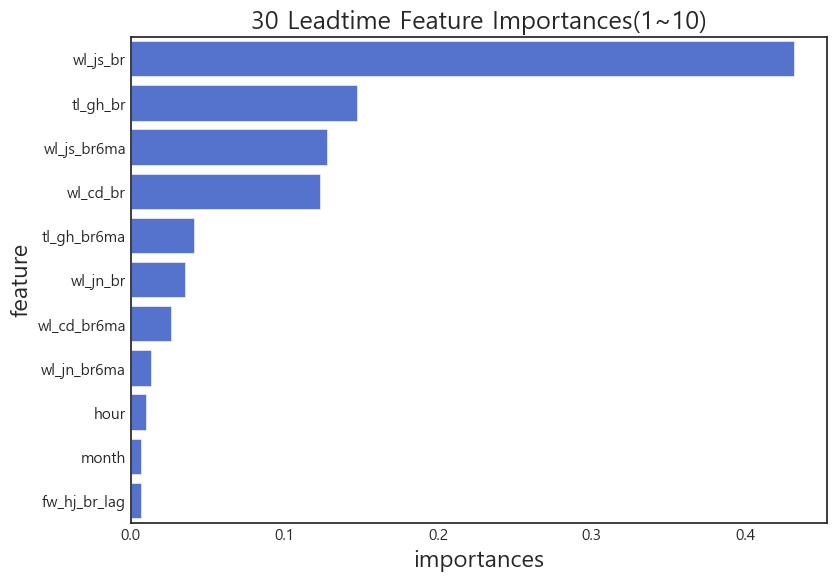

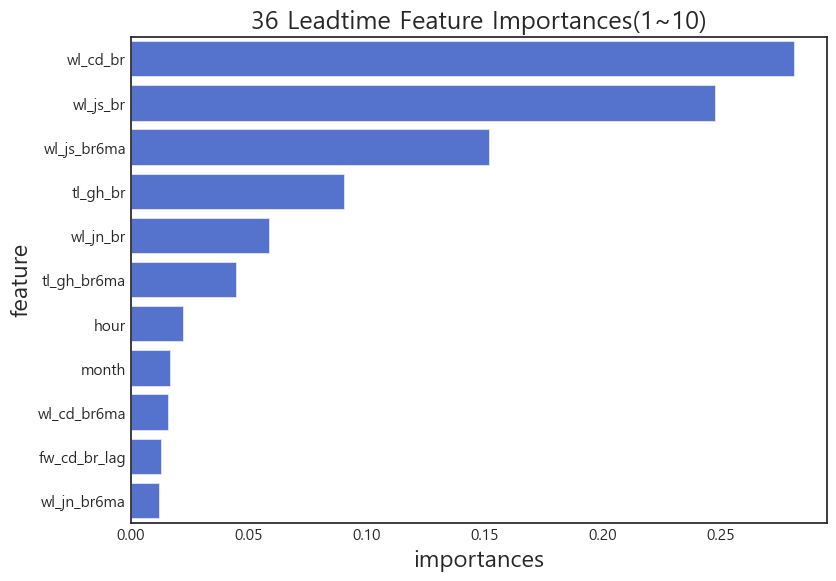

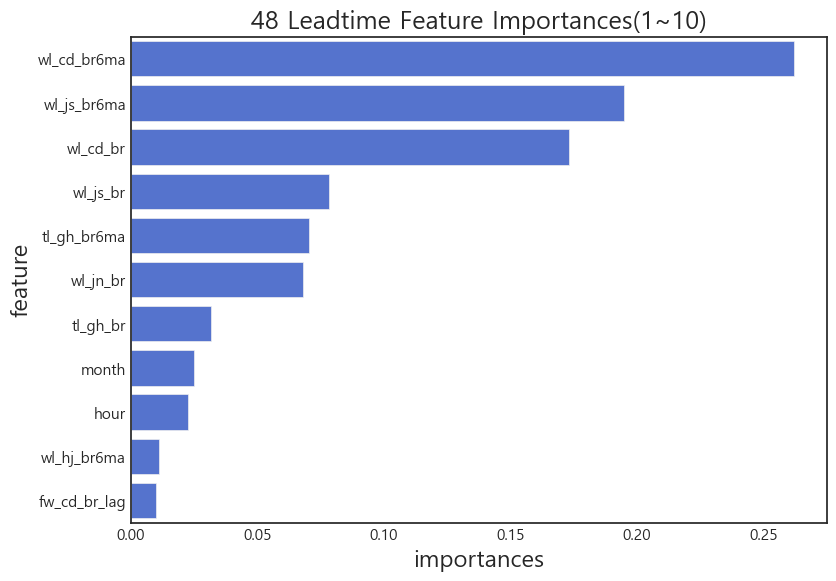

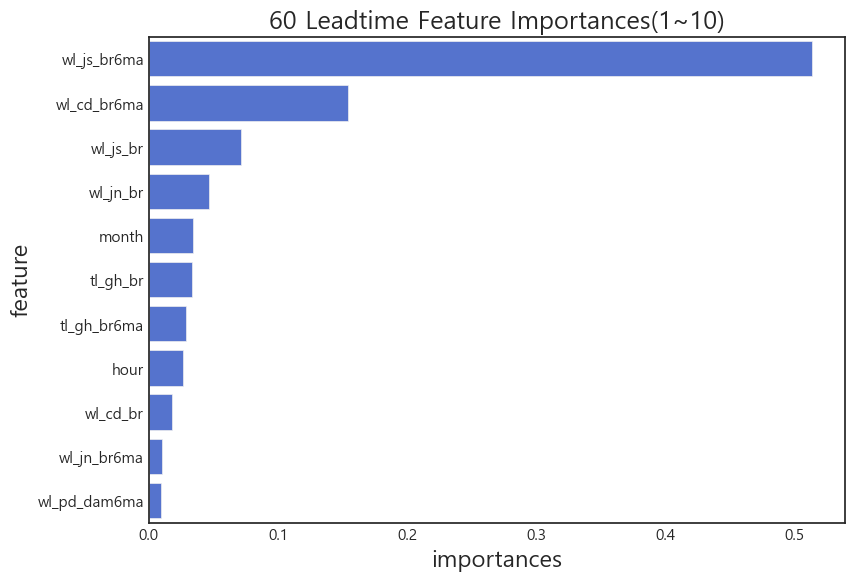

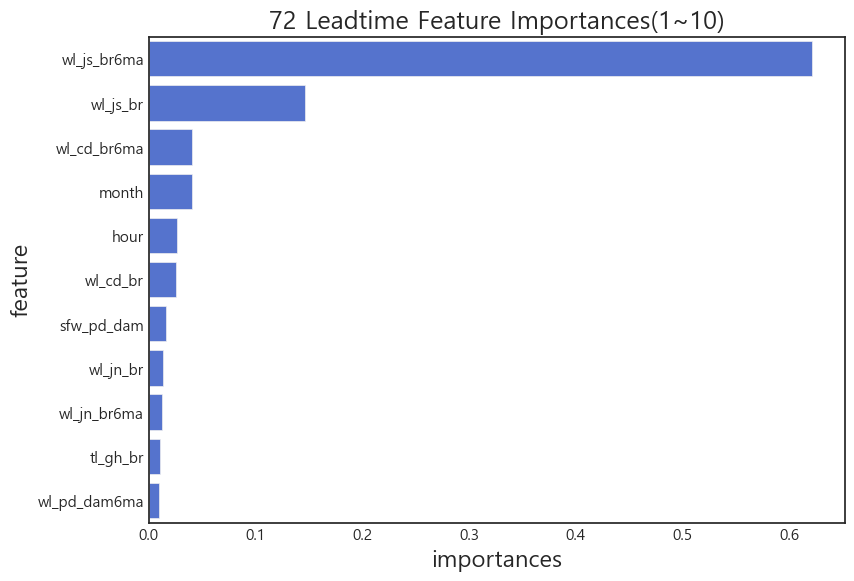

In [166]:
for i in range(len(days_list)):
    tmp_model=joblib.load(f"D:/waterdata/result/leadtime/wl_jamsu({days_list[i]}).pkl")
    importance = tmp_model.feature_importances_
    del tmp_model
    base_set=load_dataset(days_list[i],6,1)
    feature = base_set[0].columns
    importances = pd.DataFrame()
    importances['feature'] = base_set[0].columns
    importances['importances'] = importance
    importances.sort_values('importances', ascending=False, inplace=True)
    importances.reset_index(drop=True, inplace=True)
    fig=plt.figure(figsize=(8,6))
    sns.barplot(x='importances', y='feature', data=importances[:11], color='royalblue')
    plt.title('%s Leadtime Feature Importances(1~10)'%days_list[i], fontsize=18)
    fig.savefig(f"../image/importance/Importance({days_list[i]}).png", transparent = True,dpi=300, bbox_inches='tight')
    fig;